## Import

In [1]:
import numpy as np
np.random.seed(2023)
import pandas as pd
import FinanceDataReader as fdr
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# ignore warnings
import warnings ; warnings.filterwarnings('ignore')

## 위험의 구조
- 체계적 위험(시장위험)<br>
  $\bullet$ 경제$\cdot$국가$\cdot$환경$\cdot$정책 등의 예기치 못한 외부 영향으로 인해 기대수익률과 다른 수익률을 얻을 수 있다는 위험이다.<br>
  $\bullet$ 여느 금융상품에 투자함으로써 피할 수 없는 위험으로 줄일 수 없다.<br>$~~$ 그러나 높은 시장위험일수록 높은 수익률을 얻도록 보장됨에 나쁜 것만은 아니다.
- 비체계적 위험(기업고유위험)<br>
  $\bullet$ 기업의 이슈, 운영에 의한 위험이다.<br>
  $\bullet$ 비체계적 위험은 높다고 높은 수익률을 보장하지 않기에 감수하기 불필요하다. 이러한 이유로 한 자산에만 투자하기 보단 포트폴리오(분산투자)를 구성해 회피하거나 감소시킨다.

## 금융상품간 포트폴리오
- 기대수익률과 위험<br>
  $$E(R_p) = \sum_{i=1}^n w_iE(R_i)$$
  $$(w_i: \text{금융상품 } i\text{의 투자비율}, E(R_i):  \text{금융상품 } i\text{의 기대수익률}$$
  $$\sigma_p^2 = E[(R_p-\bar{R_p})^2] = E[(\sum_{i=1}^n w_iR_i - \sum_{i=1}^n w_i\bar{R_i})^2] = E[w_iw_j\sum_{i=1}^n\sum_{j=1}^n(R_i - \bar{R_i})(R_j - \bar{R_j})] = \sum_{i=1}^n\sum_{j=1}^nw_iw_jCOV_{ ij}$$
  $$(w_i: \text{금융상품 } i\text{의 투자비율}, R_i:  \text{금융상품 } i\text{의 수익률}, \bar{R_i}: \text{금융상품 } i\text{의 기대수익률}, COV_{ ij}:  \text{금융상품 } i, j\text{의 공분산})$$
- n개의 주식을 균등하게 투자한 포트폴리오의 위험을 구해보면 아래와 같다.
  $$\sigma_p^2 = \sum_{i=1}^n \frac{\sigma_i^2}{n^2} + \sum_{i=1}^n\sum_{j\neq i}\frac{COV_{ ij}}{n^2} = \frac{1}{n}\sum_{i=1}^n \frac{\sigma_i^2}{n} + \frac{(n-1)}{n}\sum_{i=1}^n\sum_{j\neq i}\frac{COV_{ ij}}{n(n-1)} = \frac{1}{n}\bar{\sigma_i}^2 + (1-\frac{1}{n})\overline{COV}_{ij} = \frac{1}{n}(\bar{\sigma_i}^2 - \overline{COV}_{ij}) + \overline{COV}_{ij}$$
  $\bullet$ 포트폴리오 투자 및 구성 자산 수($n$)를 늘릴수록 개별 주식의 위험은 의미가 없어져 비체계적 위험을 줄일 수 있음을 알 수 있다. 
- 상관계수를 사용한 정의를 통해 상품간 상관계수가 -1에 가까워 손실을 보완하는 포트폴리오가 유리함을 알 수 있다.
  $$\sigma_p^2  = \sum_{i=1}^n\sum_{j=1}^nw_iw_jCOV_{ ij} = \sum_{i=1}^n w_i^2\sigma_i^2 + \sum_{i=1}^n\sum_{j\neq i} w_iw_j\sigma_i\sigma_j\rho_{ij}$$
  

### Example 1
두 자산의 상관계수를 $-1, 0, 1$로 가정하며 포트폴리오 기대수익률, 위험을 구하시오.
- $w_A = w_B = 0.5$
- $E(R_A) = 0.2, ~\sigma_A = 0.3$
- $E(R_B) = 0.3, ~\sigma_B = 0.4$

In [2]:
# 상관계수가 1에 가까워짐은 두 주식의 방향이 같은 것으로 어느 한 주식으로 인한 손실이 발생했을 때 다른 주식도 손실이 나 2배의 손실을 부담해야 한다.
r = 0.5*0.2 + 0.5*0.3
sm = 0.5**2*0.3**2 + 0.5**2*0.4**2 + 2*0.5*0.5*0.3*0.4*-1
s0 = 0.5**2*0.3**2 + 0.5**2*0.4**2 + 2*0.5*0.5*0.3*0.4*0
sp = 0.5**2*0.3**2 + 0.5**2*0.4**2 + 2*0.5*0.5*0.3*0.4*1
print(f'포트폴리오 기대수익률: {r}')
print(f'포트폴리오 위험(rho=-1/rho=0/rho=1): {sm}/{s0}/{sp}')

포트폴리오 기대수익률: 0.25
포트폴리오 위험(rho=-1/rho=0/rho=1): 0.0025000000000000022/0.0625/0.1225


- 위의 2개 주식의 상관계수가 0이라 가정하고 최소분산포트폴리오를 구하고자 한다. 최적의 $w_A$를 구하시오. 
  $$\sigma_p^2 = w_A^2\sigma_A^2 + (1-w_A)^2\sigma_B^2 + 2w_A(1-w_A)\sigma_A\sigma_B\rho_{AB}$$
  $$\frac{\partial}{\partial w_A}\sigma_p^2 = 0 = 2\sigma_A^2w_A - 2(1-w_A)\sigma_B^2 + 2(1-w_A)\sigma_A\sigma_B\rho_{AB} - 2w_A\sigma_A\sigma_B\rho_{AB}$$
  $$w_A = \frac{\sigma_B^2 -\sigma_A\sigma_B\rho_{AB}}{\sigma_A^2 +\sigma_B^2 -2\sigma_A\sigma_B\rho_{AB}}$$ 

In [3]:
w0 = (0.4**2 - 0.3*0.4*0) / (0.3**2+0.4**2-2*0.3*0.4*0)
print(f'포트폴리오 내 주식 A 비중: {w0}')

포트폴리오 내 주식 A 비중: 0.6400000000000001


### Example 2
np.random 패키지를 사용해 경기상황 발생 확률, 3개 자산의 경기상황별 수익률, 자산별 투자 비중을 생성한 뒤 포트폴리오의 기대수익률을 구하시오.

In [4]:
# 3개 주식의 불황시, 평상시, 호황시의 수익률과 경기국면별 확률을 생성한다.
rates = np.random.randn(3, 3)
prob = np.random.rand(3)
prob = np.random.rand(3)
expRates = np.matmul(rates, prob.T)
print(f'3개 자산의 기대수익률: {expRates}')

3개 자산의 기대수익률: [-0.1749772  -0.20203662  0.93491781]


In [5]:
# 임의의 투자비중을 생성한 뒤 포트폴리오의 기대수익률을 구한다.
w = np.random.rand(3)
w /= w.sum()

portExpRate = np.sum(w*expRates)
print('5. 포트폴리오의 기대수익률: {:.2%}'.format(portExpRate))

5. 포트폴리오의 기대수익률: 45.64%


### Example 3
두 자산의 투자비율은 0부터 1까지 0.01씩 변경하며 100개의 포트폴리오를 구하고 상관계수를 $-1, 0, 1$로 가정하며 포트폴리오 기대수익률, 위험을 구하시오.
- $E(R_A) = 0.2, ~\sigma_A = 0.3$
- $E(R_B) = 0.3, ~\sigma_B = 0.4$

In [6]:
temp = pd.DataFrame({'W_A':np.arange(0, 1, 0.01),
                     'W_B':np.arange(1, 0, -0.01)})

In [7]:
# 투자비율에 따른 포트폴리오의 기대수익률
temp['R'] = temp['W_A'] * 0.2 + temp['W_B'] * 0.3

In [8]:
# 투자비율과 상관관계에 따른 포트폴리오의 위험
temp['sm'] = np.sqrt((temp['W_A']*0.3)**2+(temp['W_B']*0.4)**2+2*temp['W_A']*temp['W_B']*0.3*0.4*-1)
temp['s0'] = np.sqrt((temp['W_A']*0.3)**2+(temp['W_B']*0.4)**2+2*temp['W_A']*temp['W_B']*0.3*0.4*0)
temp['sp'] = np.sqrt((temp['W_A']*0.3)**2+(temp['W_B']*0.4)**2+2*temp['W_A']*temp['W_B']*0.3*0.4*1)

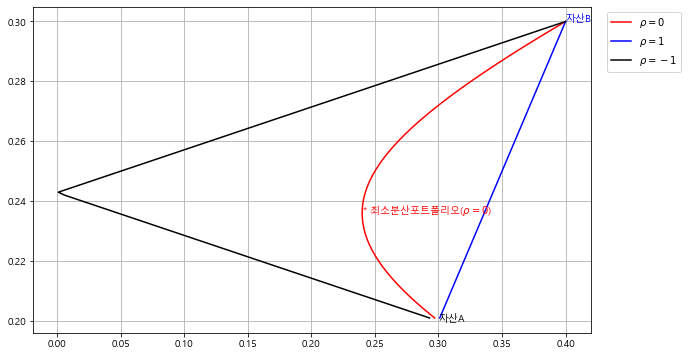

In [9]:
# 수익률과 위험이 같은 방향으로 움직이는 그래프 영역을 효율적 투자선이라 한다.
plt.figure(figsize=(10,6))
plt.plot(temp['s0'].values, temp['R'].values, color='red', label=r'$\rho = 0$')
plt.plot(temp['sp'].values, temp['R'].values, color='blue', label=r'$\rho = 1$')
plt.plot(temp['sm'].values, temp['R'].values, color='black', label=r'$\rho = -1$')
plt.text(0.3, 0.2, '자산A', color='black')
plt.text(0.4, 0.3, '자산B', color='blue')
min_pf = temp.sort_values(by='s0').iloc[0]
plt.text(min_pf['s0'], min_pf['R'], r'* 최소분산포트폴리오($\rho = 0$)', color='red')
plt.legend(bbox_to_anchor=(1.02,1))
plt.grid(True)
plt.show()

## 무위험 자산과 금융상품간 포트폴리오
- 기대수익률과 위험<br>
  $$E(R_p) = \sum_{i=1}^{n-1} w_iE(R_i) + (1-w)E(R_f), ~ w=\sum_{i=1}^{n-1} w_i$$
  $$(w_i: \text{금융상품 } i\text{의 투자비율}, 1-w:\text{무위험자산 투자비율}, E(R_i):  \text{금융상품 } i\text{의 기대수익률}, E(R_f):  \text{무위험 자산의 기대수익률})$$
  $$\sigma_p^2  = \sum_{i=1}^{n-1} w_i^2\sigma_i^2 + (1-w)^2\sigma_f^2 + \sum_{i=1}^{n-1}\sum_{j\neq i} w_iw_j\sigma_i\sigma_j\rho_{ij} + \sum_{i=1}^{n-1} w_i(1-w)\sigma_i\sigma_f\rho_{if} = \sum_{i=1}^{n-1} w_i^2\sigma_i^2  + \sum_{i=1}^{n-1}\sum_{j\neq i} w_iw_j\sigma_i\sigma_j\rho_{ij}$$
  
  $$(w_i: \text{금융상품 } i\text{의 투자비율}, \sigma_i:  \text{금융상품 } i\text{의 위험}, \rho_{ ij}:  \text{금융상품 } i, j\text{의 상관계수}, \qquad\qquad\qquad$$
  $$ 1-w: \text{무위험자산 투자비율}, \sigma_f: \text{무위험자산의 위험}, \rho_{ if}:  \text{금융상품 } i\text{와 무위험자산간 상관계수})$$

- $n-1$개 자산으로 구성된 포트폴리오 $T$와 무위험자산으로 구성된 포트폴리오라고 설명할 수 있다.
  $$E(R_p) = wE(R_T) + (1-w)E(R_f) = E(R_f) + w(E(R_T) - E(R_f)) = \text{무위험이자율} + w \times \text{위험프리미엄}$$
  $$\sigma_p^2 = w^2\sigma_T^2 + (1-w)^2\sigma_f^2 + 2w(1-w)\sigma_T\sigma_f\rho_{Tf} = w^2\sigma_T^2,~~ w=\frac{\sigma_p}{\sigma_T}$$
  
  이로써 포트폴리오의 기대수익률($E(R_p)$)과 위험($\sigma_p$)는 선형관계임을 알아낼 수 있다.<br>
  $$E(R_p) = \frac{\sigma_p}{\sigma_T}\times (E(R_T) - E(R_f)) + E(R_f) = \frac{(E(R_T) - E(R_f))}{\sigma_T}\times \sigma_p +  E(R_f)$$

## 포트폴리오 분리 정리
최적의 포트폴리오를 찾아내는 과정이다.
- 1. 투자자는 예상 수익률$\cdot$변동성 등을 고려해 투자 자산의 수익률과 리스크를 평가합니다.
- 2. 다양한 자산을, 다양한 비율로 조합해 여러 포트폴리오를 만들고 포트폴리오의 위험별 수익률을 그래프(무차별곡선)로 그린다.
- 3. `효율적 투자선 그리기`
- 4. 효율적 투자선과 접하는 무차별 곡선을 택하고 2개의 접점 중 위험회피/위험선호 성향에 따라 투자할 포트폴리오를 정한다.<br>
  $~~$ 단, 무위험자산이 포트폴리오에 포함된 경우 $(0, E(R_f))$를 지나고 효율적 투자선을 접하는 자본배분선을 구하고 자본배분선과 무차별 곡선의 접점을 투자할 포트폴리오로 선택한다.<br>
  $\bullet$ 무위험자산이 있는 경우에 위험회피적 투자자는 투자자금 일부를 무위험자산 $P_1$에, 나머지는 포트폴리오 $T$에 투자하고<br>
  $~~$ 위험지향적 투자자는 투자자금 일부를 무위험자산 $P_2$로 빌려 포트폴리오 $T$에 전액 투자한다.
<img src="첨부사진/무차별곡선.jpg">

## Example 4
애플, 페이스북, 아마존, GE, 테슬라 주식의 연수익률을 구한 뒤 임의의 자산별 투자비중을 생성해 5만개의 포트폴리오를 생성하고 아래의 문제를 푸시오.
- #### 1. 포트폴리오의 위험별 기대수익률 산점도, 최소분산 포트폴리오를 그리시오.
- #### 2. 효율적 투자선을 그리시오.

In [10]:
# 애플, 페이스북, 아마존, GE, 테슬라의 주식단축명이다.
tickers = ['AAPL', 'F', 'AMZN', 'GE', 'TSLA']
stocks = pd.concat([fdr.DataReader(ticker, '2000-01-01')['Close'] for ticker in tickers], axis=1).dropna()
stocks.columns = tickers
display(stocks)

,AAPL,F,AMZN,GE,TSLA
Date,,,,,
2010-06-29,9.148929,9.88,5.430500,86.951302,1.592667
2010-06-30,8.983214,10.08,5.463000,86.591003,1.588667
2010-07-01,8.874286,10.57,5.548000,84.789528,1.464000
2010-07-02,8.819286,10.28,5.457000,83.348343,1.280000
2010-07-06,8.879643,10.16,5.503000,83.888786,1.074000
...,...,...,...,...,...
2023-10-09,178.990005,12.07,128.259995,110.260002,259.670013
2023-10-10,178.389999,12.20,129.479996,111.480003,263.619995
2023-10-11,179.800003,12.25,131.830002,113.260002,262.989990


In [11]:
# 연단위 종가 기대수익률(=일별 종가 기대수익률 * 1년 중 시장이 열리는 일수)을 구한다.
ret_annual = stocks.pct_change(1).dropna().mean() * 250
display(ret_annual)

AAPL    0.261786
F       0.069307
AMZN    0.291049
GE      0.066609
TSLA    0.539007
dtype: float64

In [12]:
# 포트폴리오 위험 산출 목적으로 일간수익률의 공분산을 게산하고 연간단위로 변경한다.
cov_annual = stocks.pct_change(1).dropna().cov() * 250
display(cov_annual)

,AAPL,F,AMZN,GE,TSLA
AAPL,0.079071,0.034666,0.044724,0.030010,0.057158
F,0.034666,0.112236,0.034510,0.053582,0.059019
AMZN,0.044724,0.034510,0.107994,0.027606,0.066174
GE,0.030010,0.053582,0.027606,0.098984,0.040053
TSLA,0.057158,0.059019,0.066174,0.040053,0.322989


In [13]:
# 임의의 자산별 투자비중을 생성하여 지정된 포트폴리오를 만드는 함수를 정의한다.
def Generate_portfolio(N, EXPRATES, COV):
    returns = []
    for _ in range(N):
        # 자산별 투자비중 생성
        wgt = np.random.random(EXPRATES.shape[0]).round(3)
        wgt /= wgt.sum()
        # 포트폴리오 기대수익률, 위험 산출
        expPortRate = np.dot(wgt, EXPRATES) 
        riskPort = np.sqrt(np.dot(wgt.T, np.dot(COV, wgt)))
        returns.append([expPortRate, riskPort, wgt])
    return returns

In [14]:
# 5만 개의 포트폴리오를 생성한다.
port50000 = pd.DataFrame(Generate_portfolio(50000, ret_annual, cov_annual), columns=['ExpRate','Risk','Weight'])
display(port50000)

,ExpRate,Risk,Weight
0,0.213144,0.241147,"[0.17073170731707318, 0.26997476871320436, 0.3..."
1,0.262647,0.272965,"[0.16721793458287396, 0.07203234105108416, 0.1..."
2,0.267386,0.265030,"[0.19514047076689445, 0.15110098709187547, 0.2..."
3,0.268104,0.245906,"[0.3712248322147651, 0.04614093959731544, 0.34..."
4,0.324729,0.308714,"[0.15402124430955993, 0.20978755690440062, 0.2..."
...,...,...,...
49995,0.196182,0.243455,"[0.07760141093474426, 0.2782186948853616, 0.36..."
49996,0.297574,0.280375,"[0.27873894655901577, 0.2110726643598616, 0.18..."
49997,0.279202,0.333764,"[0.004691164972634871, 0.3189992181391712, 0.0..."
49998,0.336261,0.329133,"[0.055312954876273655, 0.15914604560892773, 0...."


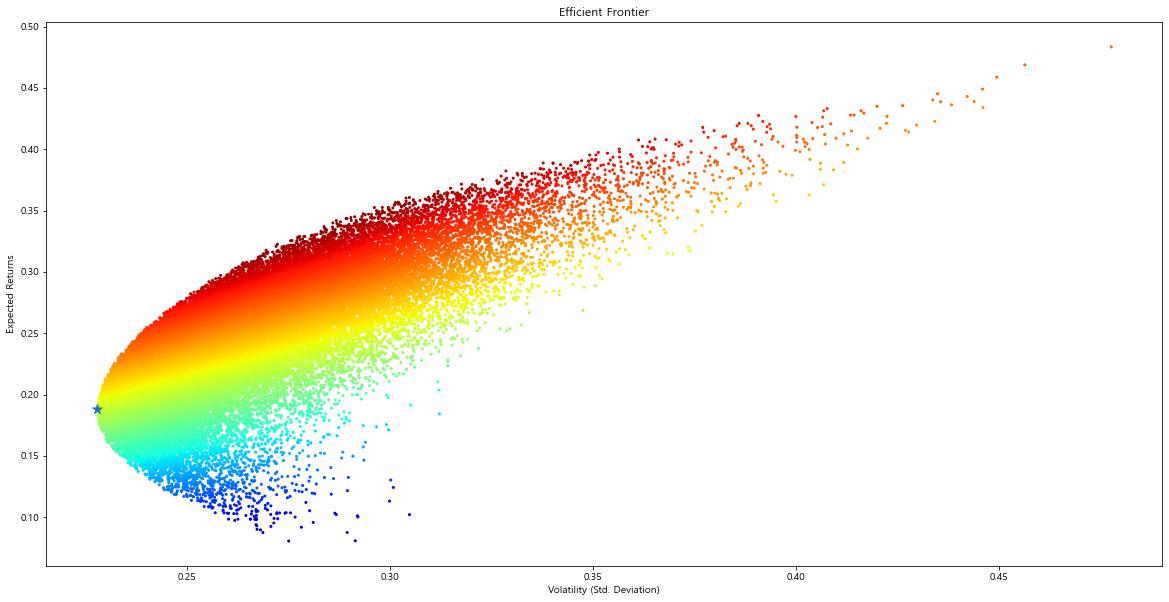

In [15]:
# 포트폴리오의 위험별 기대수익률, 최소분산 포트폴리오을 표현한다.
plt.figure(figsize=(20,10))
plt.scatter(port50000['Risk'], port50000['ExpRate'], c=port50000['ExpRate']/port50000['Risk'], marker='o', s=4, cmap='jet')
# 최소분산 포트폴리오
min_var = port50000['Risk'].argmin()
plt.scatter(port50000.loc[min_var, 'Risk'], port50000.loc[min_var, 'ExpRate'], marker="*", s=100, alpha=1.0)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

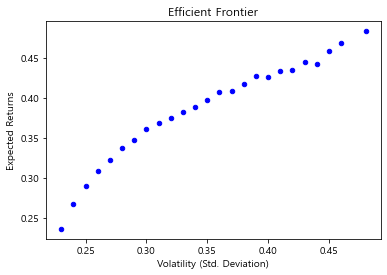

In [16]:
# 동일한 위험을 가진 포트폴리오 중 기대수익률이 큰 포트폴리오를 구한다.
'''lineplot이 아닌 scatterplot을 구하는 것은 연장선과의 접점에 해당하는 포트폴리오가 존재하지 않을 수 있기에 정확한 표기를 위함인가?'''
ef = port50000.copy()
ef['Risk'] = ef['Risk'].round(2)
ef = ef.groupby('Risk')['ExpRate'].max().reset_index()
plt.scatter(ef['Risk'], ef['ExpRate'], marker='o', s=20, color='blue')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

### Example 5
애플, 페이스북, 아마존, GE, 테슬라 주식으로 포트폴리오를 구성하려 한다.<br>
scipy.optimizer를 사용해 포트폴리오 위험을 최소화하는 투자비중과 포트폴리오의 기대수익률, 위험을 구하시오.

In [17]:
# Example 4의 ret_annual, cov_annual을 그대로 사용한다.

In [18]:
# 포트폴리오 위험을 구하는 목적함수를 정의한다.
def objective(wgt, cov):
    return np.sqrt(wgt.T @ cov @ wgt)

# 초기 투자비중을 random하게 결정
wgt = np.random.random(cov_annual.shape[0]).round(3)
wgt /= wgt.sum()

# 각 종목의 투자비중 범위는 0~100%로 튜플로 저장한다.
bnds = ((0,1), (0,1), (0,1), (0,1), (0,1))               

# 'type'의 'eq' 는 제약식 함수 값이 0과 같다는 의미이고, 'ineq' 제약식 함수 값이 0과 같지 않다는 의미이다. 
# fun'키는 제약식 함수 값을 입력한다.
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) # 투자비중 합이 1이 되도록 설정(무차입투자)

# 포트폴리오의 위험을 구하며 최적의 weight를 찾아나간다.
res = minimize(objective,     # 목적함수
               wgt,           # 초기값
               (cov_annual),  # 초기값 외에 목적함수에 전달한 매개변수
               method='SLSQP', 
               bounds=bnds, 
               constraints=cons)

In [19]:
# 최적의 투자비중, 그로부터 구한 최소분산 포트폴리오의 기대수익률과 위험은 아래와 같다.
print('최적의 투자비중: ', res['x'].round(6))
print('최소분산 포트폴리오의 기대수익률: ', np.dot(res['x'], ret_annual))
print('최소분산 포트폴리오의 위험: ', np.sqrt(res['x'].T @ cov_annual @ res['x']))

최적의 투자비중:  [0.36594  0.153129 0.208889 0.272042 0.      ]
최소분산 포트폴리오의 기대수익률:  0.1853281979714055
최소분산 포트폴리오의 위험:  0.22751945276688135


## 포트폴리오 성과측정
- 포트폴리오 내 자산배분(총 수익률 변동성의 95.6% 설명), 투자전략(타이밍, 종목선택) 등을 평가하기 위함이다.
- 사프지수, 젠센알파, 최대낙폭 지수를 성과지표로 사용한다.<br>
  $\bullet$ 사프지수: 투자수익률 대비 변동성 비율, Risk 한 단위당 얻을 수 있는 수익의 크기
  $$\text{사프지수} = \frac{\text{수익률} - \text{무위험수익률}}{\text{수익률의 표준편차}}$$
  $\bullet$ 젠센알파: 시장 대비 성과
  $$\text{젠센 알파} = \text{포트폴리오 수익률} - \text{기대수익률}$$
  $\bullet$ 최대 낙폭: 특정 투자기간 중 포트폴리오의 고점에서 저점가지의 최대 누적 손실
  $$MDD = \frac{\text{최고 가치} - \text{최저 가치}}{\text{최고 가치}}$$

## Example 6
애플, 페이스북, 아마존, GE, 테슬라 주식으로 포트폴리오를 구성하려고 한다.<br>
무위험 수익률이 0.01이라 할 때 샤프지수를 사용하여 최적의 포트폴리오를 구하시오.

In [20]:
# Example 4의 ret_annual, cov_annual을 그대로 사용한다.

In [22]:
# 샤프지수를 구하는 목적함수를 정의한다.
def objective(wgt, ret, cov, rf):
    poftExpRate = np.dot(wgt, ret)
    poftRisk = np.sqrt(np.dot(wgt.T, np.dot(cov, wgt)))
    sharpR = (poftExpRate -rf)/poftRisk
    # 최소화 함수로 최대화된 값을 구해야 하기에 역수 치환을 한다.
    return 1/sharpR

# 초기 투자비중을 random하게 결정
wgt = np.random.random(ret_annual.shape[0]).round(3)
wgt /= wgt.sum()

# Example 5와 같이 각 투자비중 범위, 제약조건을 설정한다.
bnds = ((0,1), (0,1), (0,1), (0,1), (0,1))          
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

res = minimize(objective,                    # 목적함수
               wgt,                          # 초기값
               (ret_annual, cov_annual, 0.01), # 초기값 외에 목적함수에 전달한 매개변수
               method='SLSQP', 
               bounds=bnds, 
               constraints=cons)

In [23]:
# 최적의 투자비중, 그로부터 구한 샤프지수를 최대로 하는 포트폴리오의 기대수익률과 위험은 아래와 같다.
print('최적의 투자비중: ', res['x'].round(4))
print('최소분산 포트폴리오의 기대수익률: ', np.dot(res['x'], ret_annual))
print('최소분산 포트폴리오의 위험: ', np.sqrt(res['x'].T @ cov_annual @ res['x']))

최적의 투자비중:  [0.4238 0.     0.3066 0.     0.2696]
최소분산 포트폴리오의 기대수익률:  0.34550302608279243
최소분산 포트폴리오의 위험:  0.2888884388959439
